The metric sweeps over a range of IoU thresholds, at each point calculating an F2 Score. The threshold values range from 0.5 to 0.95 with a step size of 0.05: (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95). In other words, at a threshold of 0.5, a predicted object is considered a "hit" if its intersection over union with a ground truth object is greater than 0.5.


At each threshold value t, the F2 Score value is calculated based on the number of true positives (TP), false negatives (FN), and false positives (FP) resulting from comparing the predicted object to all ground truth objects. The following equation is equivalent to F2 Score when β is set to 2:



A true positive is counted when a single predicted object matches a ground truth object with an IoU above the threshold. A false positive indicates a predicted object had no associated ground truth object. A false negative indicates a ground truth object had no associated predicted object. The average F2 Score of a single image is then calculated as the mean of the above F2 Score values at each IoU threshold:


Lastly, the score returned by the competition metric is the mean taken over the individual average F2 Scores of each image in the test dataset.

### Steps

- 1) Assign each instance(ship) a prediction by max IOU 
        
        IOU : # of Common pixels / # of union of pixels
        
- 2) Calculate metric


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import shutil
import os
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

In [2]:
sys.path.append("../fastai/")
from fastai.conv_learner import *

In [3]:
path = Path("../DATA/airbus-ship/")
files = list(path.iterdir())

In [4]:
files

[PosixPath('../DATA/airbus-ship/train_ship_segmentations.csv'),
 PosixPath('../DATA/airbus-ship/train_all_labels.csv'),
 PosixPath('../DATA/airbus-ship/test_all'),
 PosixPath('../DATA/airbus-ship/train_all_lbs.csv'),
 PosixPath('../DATA/airbus-ship/test_ship_segmentations.csv'),
 PosixPath('../DATA/airbus-ship/e5bcb0727.jpg'),
 PosixPath('../DATA/airbus-ship/models'),
 PosixPath('../DATA/airbus-ship/test_all_lbs.csv'),
 PosixPath('../DATA/airbus-ship/train_all'),
 PosixPath('../DATA/airbus-ship/segmentations'),
 PosixPath('../DATA/airbus-ship/tmp')]

### Visualize and get sample

In [7]:
train_seg_lbs = pd.read_csv(path/"segmentations/train_seg_lbs.csv")
test_seg_lbs = pd.read_csv(path/"segmentations/test_seg_lbs.csv")

In [5]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [41]:
# get all masks
img_ids = train_seg_lbs.ImageId.unique() # pick an image from training folder
img_id = np.random.choice(img_ids)
rles = train_seg_lbs[train_seg_lbs.ImageId == img_id]['EncodedPixels'].values
print(f"number of masks : {len(rles)}")

number of masks : 2


In [42]:
# get image and mask
img = open_image(str(path/"train_all"/img_id))
masks = sum([rle_decode(rle, img.shape[:2]) for rle in rles])

In [43]:
def show_imgmasks(img, masks):
    fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[2].axis('off')
    axarr[0].imshow(img)
    axarr[1].imshow(masks)
    axarr[2].imshow(img)
    axarr[2].imshow(masks, alpha=0.4)
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    plt.show()

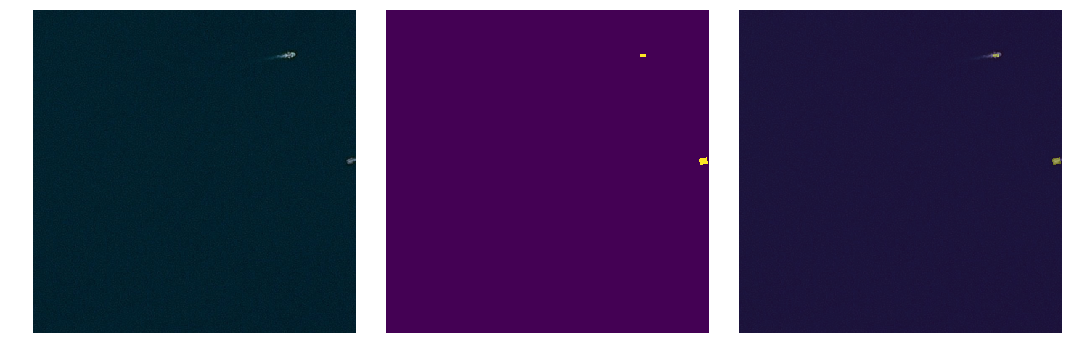

In [44]:
show_imgmasks(img, masks)

In [45]:
masks = cv2.resize(masks, (256, 256))

In [46]:
dummy_pred = np.pad(masks.copy(), 3, mode="constant", constant_values=0)

In [47]:
dummy_pred = dummy_pred[:256, :256]

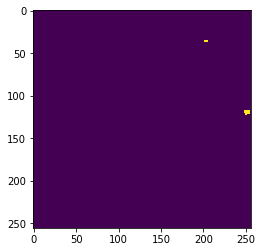

In [48]:
plt.imshow(masks)

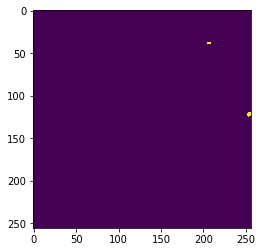

In [49]:
plt.imshow(dummy_pred)